In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

import time as time
import platform as platform

import h5py

In [3]:
colab_flag = False

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_KS_data, compute_lyapunov_spectrum

In [8]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)

FTYPE = np.float64
ITYPE = np.int64

# KS System

In [9]:
# setting up params (and saving, if applicable)
params_mat = np.array([
    [1.0, 1.0, 1.0],
    [2.0, 1.0, 1.0],
    [1.0, 2.0, 1.0],
    [1.0, 1.0, 2.0]
], dtype=FTYPE)
num_cases = params_mat.shape[0]

t0 = 0.0
T = 60000.0
delta_t = 0.1

return_params_arr = False
normalize_flag = False
alldata_withparams_flag = True

numpoints_xgrid = 64
length = 35
xgrid = length*np.linspace(0, 1, numpoints_xgrid, dtype=FTYPE)

init_state = np.sin(5*np.pi*xgrid/xgrid[-1], dtype=FTYPE)

### Creating initial data, for transient inspection and cutoff

In [10]:
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    init_state, params_mat,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag, FTYPE=FTYPE, ITYPE=ITYPE
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [11]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

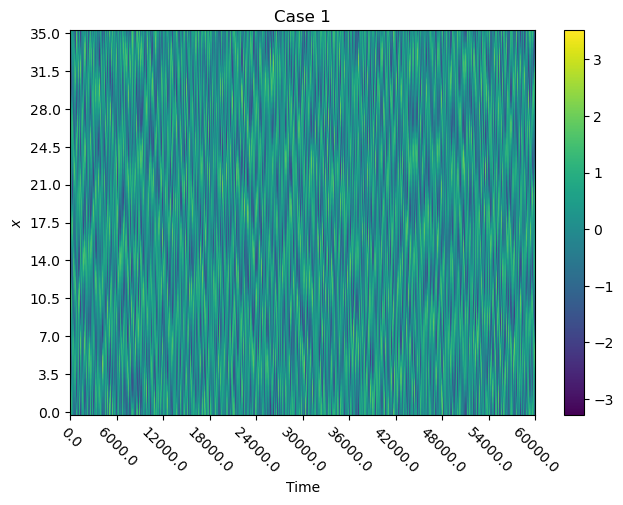

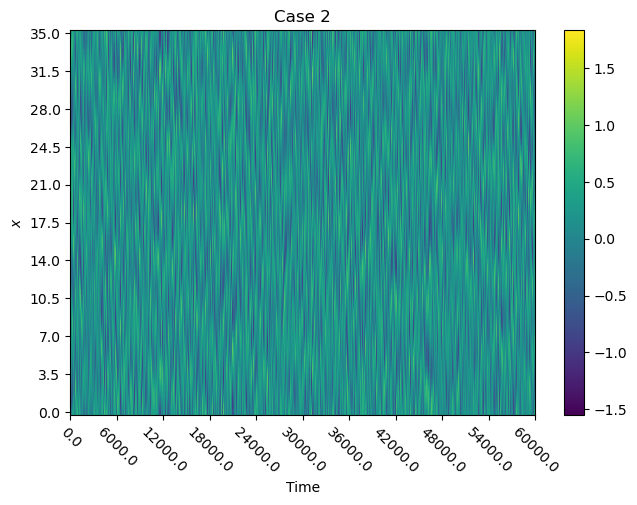

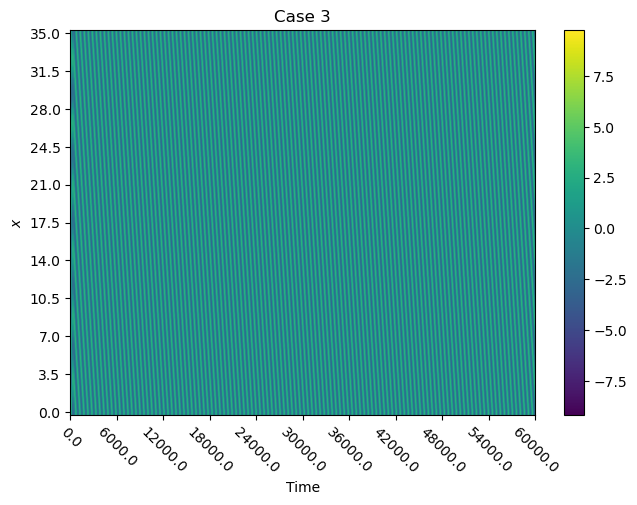

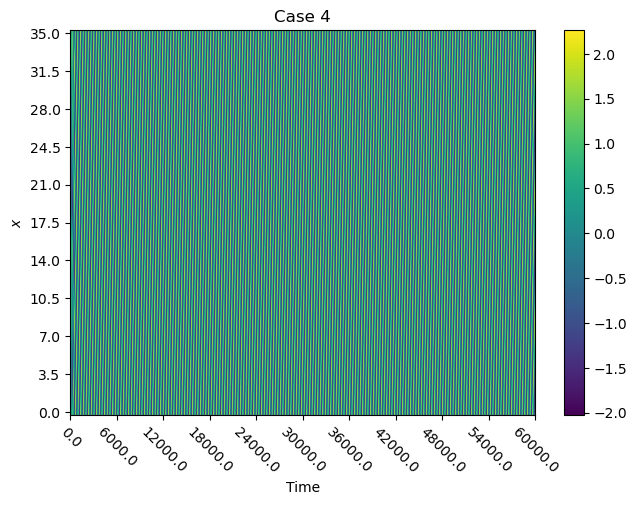

In [12]:
# plot_time_begin = 10000.
# plot_time_duration = 500

# computing xticks_snapto
chosen_interval = T//10
# chosen_interval = plot_time_duration//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = 25*np.round(100*float(sn[0:-6])/25)/100
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
#     [int(plot_time_duration/delta_t)],
    delta_t,
    all_data,#[int(plot_time_begin/delta_t):int((plot_time_begin+plot_time_duration)/delta_t), :],
    xgrid,
    xticks_snapto=xticks_snapto,
#     xticks_snapto=int(plot_time_duration//10)
)

In [13]:
# making relevant helper arrays to cut off initial transient
initial_t0 = np.array([
    10000,
    10000,
    10000,
    10000
], dtype=FTYPE) # try to keep all entries the same
initial_idx = np.zeros_like(initial_t0, dtype=ITYPE)

begin_idx = 0
len_relevant_idx = 0
for i in range(len(initial_t0)):
    init_idx = ITYPE( (initial_t0[i] + 0.5*delta_t)//delta_t )
    initial_idx[i] = init_idx + begin_idx
    len_relevant_idx += boundary_idx_arr[i] - initial_idx[i]
    begin_idx = boundary_idx_arr[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=ITYPE)
start = 0
for i in range(len(initial_t0)):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [14]:
print('boundary_idx_arr :', boundary_idx_arr)
print('initial_idx :', initial_idx)

boundary_idx_arr : [ 600001 1200002 1800003 2400004]
initial_idx : [ 100000  700001 1300002 1900003]


In [15]:
# cutting off initial transient
all_data = all_data[relevant_idx]
# init_idx = 0
# for i in range(len(boundary_idx_arr)):
#     init_idx += (initial_t0[i] + 0.25*delta_t)//delta_t
#     boundary_idx_arr[i] -= init_idx

prev_boundary_idx = 0
for i in range(num_cases):
    boundary_idx_arr[i] = prev_boundary_idx + (boundary_idx_arr[i] - initial_idx[i])
    prev_boundary_idx = boundary_idx_arr[i]

In [16]:
boundary_idx_arr

array([ 500001, 1000002, 1500003, 2000004])

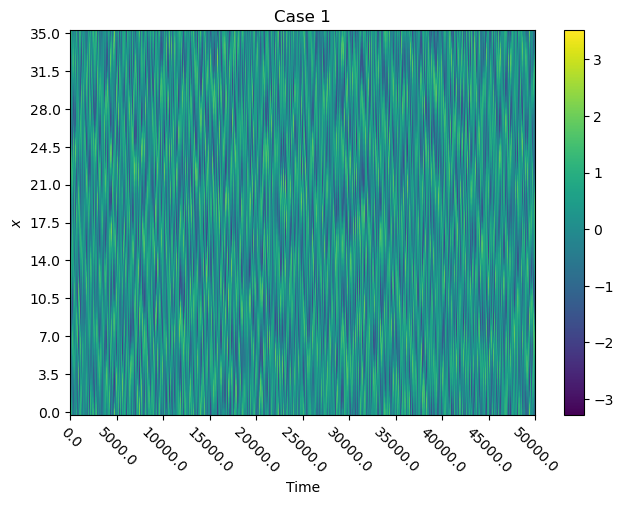

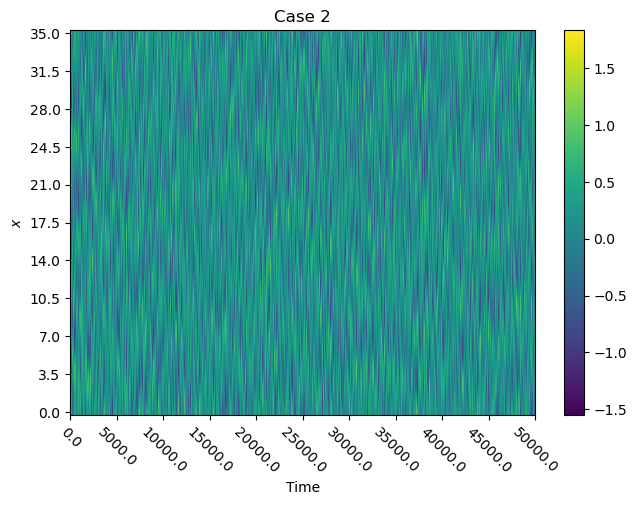

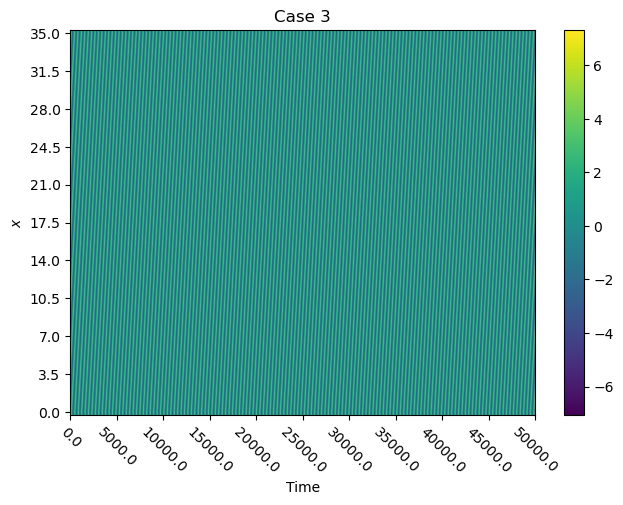

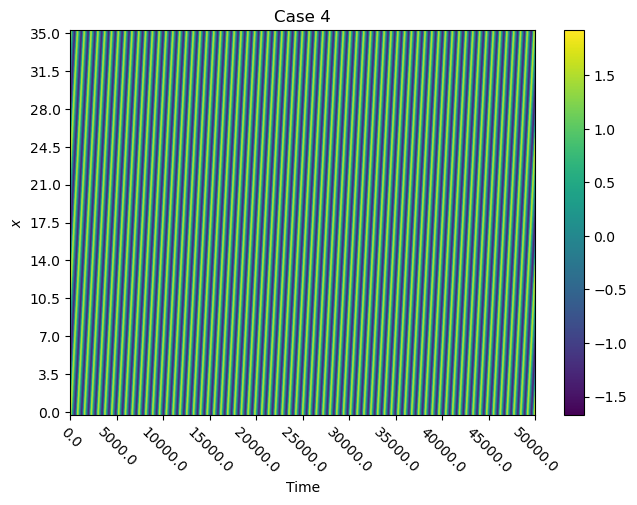

In [17]:
# computing xticks_snapto
chosen_interval = ((boundary_idx_arr[0]+np.sum(boundary_idx_arr[1:]-boundary_idx_arr[0:-1]))*delta_t/boundary_idx_arr.shape[0])//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = 25*np.round(100*float(sn[0:-6])/25)/100
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto
)

### Computing the Lyapunov spectrum

In [18]:
cdf_kwargs = {
    'T':1000,
    't0':0,
    'delta_t':delta_t,
    'xgrid':xgrid,
    'return_params_arr':False,
    'normalize':False,
    'alldata_withparams':False,
    'FTYPE':np.float64,
    'ITYPE':np.int64
}

create_data_fn = create_KS_data
num_modes = xgrid.shape[0]

init_state_mat = np.empty(shape=(num_cases, num_modes), dtype=FTYPE)
begin_idx = 0
for i in range(num_cases):
    init_state_mat[i, :] = all_data[begin_idx, 0:num_modes]
    begin_idx = boundary_idx_arr[i]

dy = 1e-9
dy_mat = np.empty(shape=num_cases, dtype=FTYPE)
begin_idx = 0
for i in range(num_cases):
    # dy_mat[i] = dy * np.mean(  np.linalg.norm( all_data[begin_idx:boundary_idx_arr[i]], axis=1 )/xgrid.shape[0]  ) timeMean of spaceMeanofSpaceNorm
    dy_mat[i] = dy * np.mean( np.linalg.norm( all_data[begin_idx:boundary_idx_arr[i], 0:num_modes], axis=0 )/( (boundary_idx_arr[i]-begin_idx)**0.5 ) ) # spaceMean of timeRMS
    begin_idx = boundary_idx_arr[i]
    print('dy_mat[{}] :'.format(i), dy_mat[i])
print('')

# cleaning up
del(all_data)
del(boundary_idx_arr)
del(params_arr)
del(normalization_constant_arr)
del(res_dict)

lpspectrum_mat, _ = compute_lyapunov_spectrum(
    create_data_fn, cdf_kwargs, num_modes, 
    init_state_mat, params_mat, dy_mat,
    zeta=10, delta_completionratio=0.1, num_exp=None, print_flag=True)

dy_mat[0] : 1.2970468217579986e-09
dy_mat[1] : 6.583553799692568e-10
dy_mat[2] : 4.7861443475055876e-09
dy_mat[3] : 1.2026115058700968e-09

number of evaluation intervals per case: 1000

case 1 completion_ratio : 0.1, elapsed_time : 20.88s, global_completion : 2.5%
case 1 completion_ratio : 0.2, elapsed_time : 40.977s, global_completion : 5.0%
case 1 completion_ratio : 0.3, elapsed_time : 60.981s, global_completion : 7.5%
case 1 completion_ratio : 0.4, elapsed_time : 81.206s, global_completion : 10.0%
case 1 completion_ratio : 0.5, elapsed_time : 101.183s, global_completion : 12.5%
case 1 completion_ratio : 0.6, elapsed_time : 121.313s, global_completion : 15.0%
case 1 completion_ratio : 0.7, elapsed_time : 141.408s, global_completion : 17.5%
case 1 completion_ratio : 0.8, elapsed_time : 161.285s, global_completion : 20.0%
case 1 completion_ratio : 0.9, elapsed_time : 181.452s, global_completion : 22.5%
case 1 completion_ratio : 1.0, elapsed_time : 201.547s, global_completion : 25.0%
c

In [19]:
lpspectrum_mat.sort(axis=1)
lpspectrum_mat = lpspectrum_mat[:, -1::-1]

In [20]:
print(lpspectrum_mat[:, 0])

[0.06465685 0.07499316 0.00690364 0.00478453]


### Computing new data based on 'initial states' from the transient cutoffs and total time from mean Lyapunov time

In [21]:
# re-creating data according to mean lyapunov time
mean_lyaptime = np.mean(lpspectrum_mat[:, 0]**(-1))
# total_lyaptimesteps_totrain = (60000+0.1*mean_lyaptime)//mean_lyaptime
# T = total_lyaptimesteps_totrain*mean_lyaptime
T = 60000

# creating new data
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    init_state_mat, params_mat,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag, FTYPE=FTYPE, ITYPE=ITYPE
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

KeyboardInterrupt: 

In [ ]:
# making ae save directory
dir_name_data = os.getcwd() + dir_sep + 'saved_data'
if not os.path.isdir(dir_name_data):
    os.makedirs(dir_name_data)

counter = 0
while True:
    dir_check = 'data_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_data + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_data = dir_name_data + dir_sep + dir_check
os.makedirs(dir_name_data)
print('dir_name_data:', dir_name_data)

total_lyaptimesteps_totrain = int((T+0.5*mean_lyaptime)//mean_lyaptime)

# saving sim data
sim_data = {
    'params_mat':params_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'numpoints_xgrid':numpoints_xgrid,
    'length':length,
    'return_params_arr':return_params_arr,
    'normalize_flag':normalize_flag,
    'alldata_withparams_flag':alldata_withparams_flag,
    'prng_seed':prng_seed,
    'total_lyaptimesteps_totrain':total_lyaptimesteps_totrain
}
with open(dir_name_data+dir_sep+'sim_data_params.txt', 'w') as f:
    f.write(str(sim_data))

In [ ]:
# saving the data
np.savez(
    dir_name_data+dir_sep+'data',
    all_data=all_data,
    boundary_idx_arr=boundary_idx_arr,
    normalization_constant_arr=[normalization_constant_arr],
    initial_t0=initial_t0,
    init_state_org=init_state,
    init_state_mat=init_state_mat,
    lyapunov_spectrum_mat=lpspectrum_mat,
    )

In [ ]:
# plotting the data and saving the plots
dir_plot = dir_name_data+dir_sep+'plots'
os.makedirs(dir_plot)

# computing xticks_snapto
chosen_interval = ((boundary_idx_arr[0]+np.sum(boundary_idx_arr[1:]-boundary_idx_arr[0:-1]))*delta_t/boundary_idx_arr.shape[0])//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = 25*np.round(100*float(sn[0:-6])/25)/100
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))
# roundtomultipleof = 5000
# xticks_snapto = int(roundtomultipleof*np.round((T/10)/roundtomultipleof, 0))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_dir=dir_plot,
    xlabel=r'Time',
    ylabel=r'$x$',
    ax_titles_list=None
)

In [ ]:
fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)

In [ ]:
fl.files